In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# from TL import preproc_TL 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch 
import numpy as np
import math 
import gc
import time 
import sys 



from time import sleep
import numpy as np
import scipy
import warnings
import pylops
warnings.filterwarnings("ignore")


from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.leastsquares import *
from pylops.utils.wavelets import ricker
from pylops.utils.signalprocessing import *


In [2]:
# data paths and parameters
data_path = '../LSTM_Otway_submitted_v2/data'
# base_path = f"{data_path}/noisy_70SNR_base_otw.npy" 
# mon_path = f"{data_path}/noisy_70SNR_mon_otw.npy" 

SNR=0.7
SNR=0.9
SNR=1.1

base_path = f"{data_path}/noisy_{SNR}SNR_base_otw.npy" 
mon_path = f"{data_path}/noisy_{SNR}SNR_mon_otw.npy" 

parm = {
 'nt': 1250,
 'ng': 605,
 'ns': 121,
 'dt': 0.002,
 'dg': 0.004000000189989805,
 'ds': 1.0,
 'ot': 0.0,
 'og': 0.012000000104308128,
 'os': 0.0}


# define the window for plotting  
# start = 100
# last =  900 

# # define the overburden window 
start = 450
last =  650 

feature_leangth = 21

start2 = 450
last2 =  900 


In [3]:
# 
base = np.load(base_path)
mon = np.load(mon_path)
ns,ng,nt = base.shape



# convert to 2D 
base = base.reshape((ns*ng,nt))
mon = mon.reshape((ns*ng,nt))

# design window 
base_win = base[:,start:last]
mon_win = mon[:,start:last]   





In [4]:
# Design filter 



nh = 41 # size of matching filter
wavc = 20 # center of matching filter

# Estimate matching filter from base to mon
Cop = VStack([MatrixMult(convmtx(base_win[iy], nh)[wavc:-nh+wavc+1]) for iy in range(base_win.shape[0])])
hmatch = Cop / mon_win.ravel()

# Apply the matching filter to base to get mon
mon_win_pred = (Cop @ hmatch).reshape(mon_win.shape)


## Apply on the reservoir part 


In [5]:


# define the reservoir from the trace 

base_win2 = base[:,start2:last2]
mon_win2 = mon[:,start2:last2]   

# Estimate matching filter from base to mon
Cop = VStack([MatrixMult(convmtx(base_win2[iy], nh)[wavc:-nh+wavc+1]) for iy in range(base_win2.shape[0])])


# Apply the matching filter to base to get mon
mon_win_pred2 = (Cop @ hmatch).reshape(mon_win2.shape)



  

In [6]:
#Convert back to 3D 

B=base_win2.reshape((ns,ng,last2-start2))
M=mon_win2.reshape((ns,ng,last2-start2))
Pr = mon_win_pred2.reshape((ns,ng,last2-start2))


# Take few shots as in the inference notebook 
B = B[50:70:2,]
M = M[50:70:2,]
Pr = Pr[50:70:2,]
ns,ng,nt_ = B.shape



In [7]:
# Metrics 

def RMS(a):
    N = a.shape[0]
    return np.sqrt(1/N * np.sum(a**2))
#     return np.sqrt(np.mean(a**2))

def NRMS (B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    num = RMS(b-m)
    den = RMS(b)+RMS(m)
    score = 200 * num/den
    return score
    
def phi(b,m):
    num = np.sum(b*m)
    den = np.sqrt(np.sum(b**2)*np.sum(m**2))
    return num/den
    
def predictability(B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    w = b.shape[-1]
    tao = 0
    num = 0 
    den = 0
    for tao in range(w//2): 
        phi_bm = phi(b[tao:tao+w//2],m[tao:tao+w//2])
        phi_bb = phi(b[tao:tao+w//2],b[tao:tao+w//2])
        phi_mm = phi(m[tao:tao+w//2],m[tao:tao+w//2])
        num   += phi_bm * phi_bm
        den   += phi_bb * phi_mm
    score = 100 * num/den
    return score


metric window is [0.9-1.35]


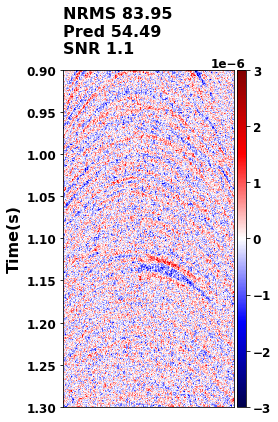

In [8]:
''' Shot differeces plots ''' 
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Shot plotting 

# matplotlib.rc('image', cmap='gray')    
matplotlib.rc('image', cmap='seismic') 
font = {
'weight' : 'bold',
'size'   : 12}
matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 12})
dt = 0.002
vmax = 3e-6
vmin = -vmax
# vmax = .15
# vmin = -.15
# vmin, vmax = np.percentile((Mclean-base).T,[2,98])


ncols=5
#-----------------------------------------------------------


def plot_differences(shot1,shot2,ncols,savedir,metric=True):

    # Measure metric window
    ti = 0
    tf = shot1.shape[-1]//2 
    print(f"metric window is [{start*dt}-{(start+tf)*dt}]")
    fig, ax = plt.subplots(1,ncols,figsize=(16,5))
    for i in range (ncols):
        nrms = NRMS(shot1[i],shot2[i],ti,tf)
        pred = predictability(shot1[i],shot2[i],ti,tf)
        
        im = ax[i].imshow(shot1[i].T - shot2[i].T ,
            vmin=vmin,vmax=vmax,extent=[0,2000,last*dt,start*dt])
        ax[i].axis("tight")
        ax[i].set_ylabel("Time(s)",fontsize=16,fontweight='bold')
        ax[i].axes.xaxis.set_visible(False)
        if metric: 
            ax[i].text(0.05,.85,
                f"NRMS {nrms:.2f} \nPred {pred:.2f}",size=16)

        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout(pad=1.0)
    fig.savefig(savedir, bbox_inches='tight')


# plot_differences(M,Pr-Pr.mean(axis=2, keepdims=True),
#                 ncols=5,savedir='./Fig/MF_diff')
    
    
    
shot1 = M[2,]
shot2 = Pr[2,]  
    
# Measure metric window
ti = 0
tf = shot1.shape[-1]//2 
print(f"metric window is [{start*dt}-{(start+tf)*dt}]")
fig, ax = plt.subplots(1,1,figsize=(4,6))
nrms = NRMS(shot1,shot2,ti,tf)
pred = predictability(shot1,shot2,ti,tf)        
im = ax.imshow(shot1.T - shot2.T ,
            vmin=vmin,vmax=vmax,extent=[0,2000,last*dt,start*dt])
ax.axis("tight")
ax.set_ylabel("Time(s)",fontsize=16,fontweight='bold')
ax.axes.xaxis.set_visible(False)
ax.text(0.05,.88,
                f"NRMS {nrms:.2f} \nPred {pred:.2f}\nSNR {SNR:0.1f}",size=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout(pad=1.0)
fig.savefig(f'./Fig/MF_diff_SNR{SNR}.png', bbox_inches='tight')




In [9]:
M.shape

(10, 609, 450)

In [10]:
base_win2.shape

(73080, 450)